#1. Install dependencies

In [1]:
#@markdown Run this cell to install the dependecies
!pip install python-bioformats
!pip install python-javabridge

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
import h5py
import scipy.stats as stats
import tifffile
from skimage import io
from tqdm.notebook import tqdm
from scipy import interpolate
import pickle
from IPython.display import HTML
import random
from PIL import Image
import pandas as pd
from skimage.feature import peak_local_max
from scipy.signal import convolve2d
from numpy.random import default_rng
import numbers

from google.colab import drive
drive.mount('/content/gdrive')

# matplotlib.use('TKAgg')

def project_01(im):
    # Squeeze the pixels value to be in range [0, 1]
    if (im.sum() == 0):
        return im
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val) / (max_val - min_val)

def project_percentile(im, percentile):
    # Squeeze the pixels value to be in range [0, percentile_value]
    if (im.sum() == 0):
        return im
    im = np.squeeze(im)
    percentile_val = np.percentile(im, percentile)
    comp_percentile_val = np.percentile(im, 2 * (100 - percentile))
    return (im - comp_percentile_val) / percentile_val

def read_cif(data_path, channels, image_size):
    # Read cif file and pad each image and create tif for all specified channels
    javabridge.start_vm(class_path=bioformats.JARS, max_heap_size='8G')
    print('-I- Converting CIF to TIF')
    # set default parameters
    dirs = []
    # call bioformats reader
    for filename in os.listdir(data_path):
        if filename.endswith('.cif'):
            np.random.seed(123)
            # Make new dir for this file
            dirs.append(os.path.join(data_path, filename[:-4]))
            if (not os.path.isdir(os.path.join(data_path, filename[:-4]))):
                os.mkdir(os.path.join(data_path, filename[:-4]))

            single_channel_tensors = []
            with bioformats.get_image_reader(key='tmp', path=os.path.join(data_path, filename)) as reader:
                image_count = javabridge.call(reader.metadata, "getImageCount", "()I")
                # channel_count = javabridge.call(reader.metadata, "getChannelCount", "(I)I", 0)

                for j, ch in enumerate(channels):
                    images = []
                    # I use channel - 1 because channel 6 is named channel 5 in the cif file...
                    # I iterate in jumps of two indices because each second image is a mask image and irrelevant
                    print("-I- Reading channel {}".format(ch))
                    for image in range(image_count)[::2]:
                        images.append(reader.read(c=channels[j] - 1, series=image))

                    print("-I- Cropping and padding")
                    cropped_images_list = []
                    for image in images:
                        cropped_images_list.append(__pad_and_project(image, image_size))

                    cropped_images_this_channel = np.expand_dims(np.array(cropped_images_list), axis=3)

                    print('-I- Saving channel', ch)

                    with tifffile.TiffWriter(os.path.join(data_path, '{}/{}_ch{}.tif'.format(filename[:-4], filename[:-4], ch)), bigtiff=True) as stack:
                        stack.write(cropped_images_this_channel.squeeze(), contiguous=True)

    javabridge.kill_vm()
    return dirs

def __pad_and_project(image, image_size):
    # make all images the same size: padding images with background noise of croppping images
    if (not (image.sum() == 0)):
        min_val = image.min()
        max_val = image.max()
        image = 255 * (image - min_val) / (max_val - min_val)

    sample = image[int(image.shape[0] / 2) - 4:int(image.shape[0] / 2) + 4, :8]

    std = np.std(sample)
    mean = np.mean(sample)

    if (image_size < image.shape[0]) & (image_size < image.shape[1]):
        return image[:image_size, :image_size]
    elif image_size < image.shape[0]:
        tmp = np.random.normal(mean, std, [image_size, image_size])
        tmp[:image_size, :image.shape[1]] = image[:image_size, :]
        return tmp
    elif image_size < image.shape[1]:
        tmp = np.random.normal(mean, std, [image_size, image_size])
        tmp[:image.shape[0], :image_size] = image[:, :image_size]
        return tmp
    else:
        tmp = np.random.normal(mean, std, [image_size, image_size])
        tmp[:image.shape[0], :image.shape[1]] = image
        return tmp

def LoadTIFF(file, path, size=None, cell_indices=None):
    # Load a tiff stack
    tiff = Image.open(os.path.join(path, file))
    tiff.seek(0)
    x0 = np.array(tiff)
    if size == None:
        size = tiff.n_frames
    else:
        size = np.min([size, tiff.n_frames])
    data = []
    if(cell_indices is None):
        rng = default_rng()
        cell_indices = rng.choice(tiff.n_frames, size=np.min([tiff.n_frames, size]), replace=False)
    for i in range(size):
        try:
            tiff.seek(cell_indices[i])
        except:
            print('Specified stack length is too big - Finish reading the TIFF')
            break
        tmp = np.array(tiff)
        if (tmp.size > 1):
            data.append(tmp)
        else:
            data.append(np.zeros_like(x0))

    return np.array(data), cell_indices

def ShrinkImages(data, size, save_coord=False):
    # Crop image according to size
    left = int(np.argmax(data) % data.shape[1]) - int(size / 2)
    down = int(np.argmax(data) / data.shape[1]) - int(size / 2)
    right = left + size
    up = down + size
    if (left < 0):
        left = 0
        right = size
    if (down < 0):
        down = 0
        up = size
    if (right > data.shape[1]):
        right = data.shape[1]
        left = data.shape[1] - size
    if (up > data.shape[0]):
        up = data.shape[0]
        down = data.shape[0] - size

    if save_coord:
        return data[down:up, left:right], np.array([down, left])
    else:
        return data[down:up, left:right]

def ShrinkImages_ch4(data, size, ch2_shrink_coord, save_coord=False):
    # Special crop for ch4 based on ch2 crop
    down, left = ch2_shrink_coord.astype(int)
    right = left + size
    up = down + size
    if save_coord:
        return data[down:up, left:right], np.array([down, left])
    else:
        return data[down:up, left:right]

def localize_emitters(orig_img, img, img_ch6, img_size, conf_threshold, detection_mode, verbose):
    # Localize all the emitters in an image. The detection mode selects whether we fit beads
    # to a singla Gaussian or loci to two Gaussians.
    # Initialize parameters
    pred_params_list = []
    fit_quality_list = []
    confidence_list = []

    patch_size = 11
    xy = np.zeros([2, int(patch_size ** 2)])
    for i1 in range(patch_size):
        for j1 in range(patch_size):
            xy[:, int(i1 + patch_size * j1)] = [i1, j1]

    xy_big = np.zeros([2, int(img_size ** 2)])
    for i1 in range(img_size):
        for j1 in range(img_size):
            xy_big[:, int(i1 + img_size * j1)] = [i1, j1]

    # Find potential peaks
    min_dist = 5
    potential_peaks_map = np.zeros_like(img)
    num_of_peaks = 0
    ind_list = []
    potential_peaks = peak_local_max(img, num_peaks=5, threshold_rel=0.5)
    for i in range(potential_peaks.shape[0]):
        if(potential_peaks_map[potential_peaks[i, 0], potential_peaks[i, 1]] == 0):
            num_of_peaks += 1
            ind_list.append(i)
            down = np.max([0, potential_peaks[i, 0]-min_dist])
            up = np.min([img_size, potential_peaks[i, 0]+min_dist+1])
            left = np.max([0, potential_peaks[i, 1]-min_dist])
            right = np.min([img_size, potential_peaks[i, 1]+min_dist+1])
            potential_peaks_map[down:up, left:right] = 1

    potential_peaks = potential_peaks[ind_list]

    # Filtering 0 loci or more than 2 loci
    if (num_of_peaks < 1):
        if (verbose):
            plt.figure()
            plt.imshow(img)
            plt.title('Did not detected loci')
            plt.show()
        return pred_params_list, fit_quality_list, confidence_list
    elif(num_of_peaks > 2):
        if (verbose):
            plt.figure()
            plt.imshow(img)
            plt.title('Too many loci detected - not analyzing more than 2')
            plt.show()
        return pred_params_list, fit_quality_list, confidence_list

    for peak in range(num_of_peaks):
        # Observe only small patch around peak
        down = np.max([0, potential_peaks[peak, 0]-patch_size//2])
        up = np.min([img_size-1, potential_peaks[peak, 0]+patch_size//2])
        left = np.max([0, potential_peaks[peak, 1]-patch_size//2])
        right = np.min([img_size-1, potential_peaks[peak, 1]+patch_size//2])

        if(up+1-down < patch_size or right+1-left<patch_size):
            if (verbose):
                print("Locus is too close to image boundaries")
            if (peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        zobs = (img[down:up+1, left:right+1]).reshape(1, -1).squeeze()

        # Position of maximal pixel in current patch
        max_ind = np.argmax(zobs.reshape([patch_size, patch_size]))
        try:
            if(detection_mode == "beads"):
                guess = [np.median(zobs), np.max(zobs), potential_peaks[peak, 1] - left, potential_peaks[peak, 0] - down, 2, 2]
                bounds = ([0, 0, potential_peaks[peak, 1] - 0.5 - left, potential_peaks[peak, 0] - 0.5 - down, 0.5, 0.5],
                          [np.inf, np.inf, potential_peaks[peak, 1] + 0.5 - left, potential_peaks[peak, 0] + 0.5 - down, 4, 4])
                pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess, bounds=bounds)
            else:
                guess = [np.median(zobs), np.median(zobs), int(max_ind % (right-left)), int(max_ind / (up-down)), 3, 3,
                         np.pi/2, np.max(zobs), potential_peaks[peak, 1] - left, potential_peaks[peak, 0] - down, 2, 2]
                bounds = ([0, 0, 0, 0, 3, 3, 0, 0, potential_peaks[peak, 1] - 0.5 - left, potential_peaks[peak, 0] - 0.5 - down, 0.5, 0.5],
                          [np.max(zobs), np.max(zobs), img_size - 1, img_size - 1, 4, 4, 2*np.pi, np.inf, potential_peaks[peak, 1] + 0.5 - left,
                           potential_peaks[peak, 0] + 0.5 - down, 4, 4])
                pred_params, uncert_cov = opt.curve_fit(gauss_on_gauss, xy, zobs, p0=guess, bounds=bounds)
        except Exception as e:
            if(verbose):
                print("Could not fit to model")
            if(peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        if(np.abs(pred_params[2] - bounds[0][2]) < 1e-3 or
                np.abs(pred_params[2] - bounds[1][2]) < 1e-3 or
                np.abs(pred_params[3] - bounds[0][3]) < 1e-3 or
                np.abs(pred_params[3] - bounds[1][3]) < 1e-3):
            if(peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        if(detection_mode == "beads"):
            loci_sig_x = pred_params[4]
            loci_sig_y = pred_params[5]
        else:
            loci_sig_x = pred_params[10]
            loci_sig_y = pred_params[11]
            cell_sig_x = pred_params[4]
            cell_sig_y = pred_params[5]

        # Remove fit to bound values
        if (loci_sig_x > 3.999 or loci_sig_y > 3.999):
            if(verbose):
                print("Predicted sigma is too big")
            if(peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        if (detection_mode != "beads" or detection_mode != "2D_beads"):
            # Do not allow the cell sigma be smaller than the loci sigma
            # Cell sigma should be at least 2 times bigger than loci sigma
            if (cell_sig_x < 2*loci_sig_x or cell_sig_y < 2*loci_sig_y):
                if (verbose):
                    title = 'Cell shape is too small compared of the locus shape'
                    # Add zobs offset to localizations
                    pred_params[2] += left
                    pred_params[3] += down
                    if (detection_mode != "beads"):
                        pred_params[8] += left
                        pred_params[9] += down
                    plot_cell_fit(img_size, img, pred_params, title)
                if (peak < num_of_peaks - 1):
                    continue
                return pred_params_list, fit_quality_list, confidence_list

            # Filter cases where the fitted cell intensity is much higher than the loci
            if (pred_params[1] / pred_params[7] > 1.5):
                if (verbose):
                    title = 'Cell intensity is too high compared to the loci intensity'
                    # Add zobs offset to localizations
                    pred_params[2] += left
                    pred_params[3] += down
                    if (detection_mode != "beads"):
                        pred_params[8] += left
                        pred_params[9] += down
                    plot_cell_fit(img_size, img, pred_params, title)
                if (peak < num_of_peaks - 1):
                    continue
                return pred_params_list, fit_quality_list, confidence_list

        if (detection_mode == "beads"):
            fit = gauss2d(xy, *pred_params)
        else:
            fit = gauss_on_gauss(xy, *pred_params)

        # Calculate RMS
        fit_quality = 1 - np.sqrt(np.mean((zobs / np.max(zobs) - fit / np.max(fit)) ** 2))

        # Ensure fit quality is high enough
        if (fit_quality > 0.9):
            confidence = fit_quality * np.max(orig_img)
            confidence = np.min([100, confidence])
            confidence /= 2
            if (confidence < conf_threshold):
                if (peak < num_of_peaks - 1):
                    continue
                return pred_params_list, fit_quality_list, confidence_list

            # Add zobs offset to localizations
            pred_params[2] += left
            pred_params[3] += down
            if(detection_mode != "beads"):
                pred_params[8] += left
                pred_params[9] += down

            # Add emitter to list
            if(verbose):
                plt.figure()
                plt.suptitle('Accepted emitter')
                plt.subplot(121)
                plt.title('Image (ch2/4)')
                plt.imshow(img)
                plt.subplot(122)
                if(detection_mode == "beads"):
                    plt.imshow(gauss2d(xy_big, *pred_params).reshape([img_size, img_size]))
                    plt.scatter(pred_params[2], pred_params[3], c='r', s=1)
                else:
                    plt.imshow(gauss_on_gauss(xy_big, *pred_params).reshape([img_size, img_size]))
                    plt.scatter(pred_params[8], pred_params[9], c='r', s=1)
                plt.title('Fit')
                plt.show()

            pred_params_list.append(pred_params)
            fit_quality_list.append(fit_quality)
            confidence_list.append(confidence)
        else:
            if (peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

    return pred_params_list, fit_quality_list, confidence_list

def localize_emitters_bs(orig_img, img, img_size, conf_threshold, detection_mode, verbose):
    # Same as localize_emitter function; however, here the results are divided to multiple batches
    # This is done for statistical analysis of the results.
    # Initialize parameters
    pred_params_list = []
    fit_quality_list = []
    confidence_list = []

    patch_size = 13
    xy = np.zeros([2, int(patch_size ** 2)])
    for i1 in range(patch_size):
        for j1 in range(patch_size):
            xy[:, int(i1 + patch_size * j1)] = [i1, j1]

    xy_big = np.zeros([2, int(img_size ** 2)])
    for i1 in range(img_size):
        for j1 in range(img_size):
            xy_big[:, int(i1 + img_size * j1)] = [i1, j1]

    # Find potential peaks
    min_dist = 5
    potential_peaks_map = np.zeros_like(img)
    num_of_peaks = 0
    ind_list = []
    potential_peaks = peak_local_max(img, num_peaks=5, threshold_rel=0.5)
    for i in range(potential_peaks.shape[0]):
        if(potential_peaks_map[potential_peaks[i, 0], potential_peaks[i, 1]] == 0):
            num_of_peaks += 1
            ind_list.append(i)
            down = np.max([0, potential_peaks[i, 0]-min_dist])
            up = np.min([img_size, potential_peaks[i, 0]+min_dist+1])
            left = np.max([0, potential_peaks[i, 1]-min_dist])
            right = np.min([img_size, potential_peaks[i, 1]+min_dist+1])
            potential_peaks_map[down:up, left:right] = 1

    potential_peaks = potential_peaks[ind_list]

    # Filtering 0 loci or more than 2 loci
    if (num_of_peaks < 1):
        if (verbose):
            plt.figure()
            plt.imshow(img)
            plt.title('Did not detected loci')
            plt.show()
        return pred_params_list, fit_quality_list, confidence_list
    elif(num_of_peaks > 2):
        if (verbose):
            plt.figure()
            plt.imshow(img)
            plt.title('Too many loci detected - not analyzing more than 2')
            plt.show()
        return pred_params_list, fit_quality_list, confidence_list

    for peak in range(num_of_peaks):
        # Observe only small patch around peak
        down = np.max([0, potential_peaks[peak, 0] - patch_size // 2])
        up = np.min([img_size, potential_peaks[peak, 0] + patch_size // 2 + 1])
        left = np.max([0, potential_peaks[peak, 1] - patch_size // 2])
        right = np.min([img_size, potential_peaks[peak, 1] + patch_size // 2 + 1])

        if(up-down < patch_size or right-left<patch_size):
            if(down == 0):
                up = patch_size
            elif(up == img_size-1):
                down = img_size - patch_size
            if (left == 0):
                right = patch_size
            elif (right == img_size - 1):
                left = img_size - patch_size

        zobs = (img[down:up, left:right]).reshape(1, -1).squeeze()

        # Position of maximal pixel in current patch
        try:
            if(detection_mode == "beads" or detection_mode == "2D_beads"):
                guess = [np.median(zobs), np.max(zobs), potential_peaks[peak, 1] - left, potential_peaks[peak, 0] - down, 2, 2]
                bounds = ([0, 0, potential_peaks[peak, 1] - 0.5 - left, potential_peaks[peak, 0] - 0.5 - down, 0.5, 0.5],
                          [np.inf, np.inf, potential_peaks[peak, 1] + 0.5 - left, potential_peaks[peak, 0] + 0.5 - down, 4, 4])
                pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess, bounds=bounds)
            else:
                guess = [np.median(zobs), np.median(zobs), potential_peaks[peak, 0] - left, potential_peaks[peak, 1] - down, 3, 3,
                         np.pi/2, np.max(zobs), potential_peaks[peak, 1] - left, potential_peaks[peak, 0] - down, 0.75, 0.75]
                bounds = ([0, 0, potential_peaks[peak, 1] - 5 - left, potential_peaks[peak, 0] - 5 - down, 3, 3, 0,
                           2 * zobs.std(), potential_peaks[peak, 1] - 2 - left, potential_peaks[peak, 0] - 2 - down, 0.75, 0.75],
                          [np.inf, np.inf, potential_peaks[peak, 1] + 4 - left, potential_peaks[peak, 0] + 4 - down, 4, 4, 2*np.pi,
                           np.inf, potential_peaks[peak, 1] + 2 - left, potential_peaks[peak, 0] + 2 - down, 2.5, 2.5])
                pred_params, uncert_cov = opt.curve_fit(gauss_on_gauss, xy, zobs, p0=guess, bounds=bounds, maxfev=15000)
        except Exception as e:
            if(verbose):
                print("Could not fit to model")
            if(peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        if(np.abs(pred_params[2] - bounds[0][2]) < 1e-3 or
                np.abs(pred_params[2] - bounds[1][2]) < 1e-3 or
                np.abs(pred_params[3] - bounds[0][3]) < 1e-3 or
                np.abs(pred_params[3] - bounds[1][3]) < 1e-3):
            if(peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

        if(detection_mode == "beads" or detection_mode == "2D_beads"):
            loci_sig_x = pred_params[4]
            loci_sig_y = pred_params[5]
        else:
            loci_sig_x = pred_params[10]
            loci_sig_y = pred_params[11]
            cell_sig_x = pred_params[4]
            cell_sig_y = pred_params[5]

        # Do not allow the cell sigma be smaller than the loci sigma
        # Cell sigma should be at least 3 times bigger than loci sigma
        if (detection_mode != "beads" and detection_mode != "2D_beads"):
            if (cell_sig_x < 1.5*loci_sig_x or cell_sig_y < 1.5*loci_sig_y):
                if (peak < num_of_peaks - 1):
                    continue
                return pred_params_list, fit_quality_list, confidence_list

        if (detection_mode == "beads" or detection_mode == "2D_beads"):
            fit = gauss2d(xy, *pred_params)
        else:
            fit = gauss_on_gauss(xy, *pred_params)

        # Calculate RMS
        fit_quality = 1 - np.sqrt(np.mean((zobs / np.max(zobs) - fit / np.max(fit)) ** 2))

        # Ensure fit quality is high enough
        if (fit_quality > 0.9):
            confidence = fit_quality * np.max(orig_img)
            confidence = np.min([100, confidence])
            confidence /= 2
            if (confidence < conf_threshold):
                if (peak < num_of_peaks - 1):
                    continue
                return pred_params_list, fit_quality_list, confidence_list

            # Add zobs offset to localizations
            pred_params[2] += left
            pred_params[3] += down
            if(detection_mode != "beads" and detection_mode != "2D_beads"):
                pred_params[8] += left
                pred_params[9] += down

            # Add emitter to list
            pred_params_list.append(pred_params)
            fit_quality_list.append(fit_quality)
            confidence_list.append(confidence)
        else:
            if (peak < num_of_peaks - 1):
                continue
            return pred_params_list, fit_quality_list, confidence_list

    return pred_params_list, fit_quality_list, confidence_list

def localize_beads(orig_img, img, img_size, conf_threshold, verbose):
    # Localizes beads in the given image
    xy = np.zeros([2, int(img_size ** 2)])
    for i1 in range(img_size):
        for j1 in range(img_size):
            xy[:, int(i1 + img_size * j1)] = [i1, j1]

    # Fit the patch to a gaussian
    zobs = (img).reshape(1, -1).squeeze()

    max_ind = np.argmax(zobs.reshape([img_size, img_size]))
    guess = [np.median(zobs), np.max(zobs), int(max_ind % img_size), int(max_ind / img_size), 2, 2]
    bounds = ([0, 0, 0, 0, 0.5, 0.5], [np.inf, np.inf, img_size - 1, img_size - 1, 4, 4])
    try:
        pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess, bounds=bounds, maxfev=10000)
    except:
        return None, None, None

    # Remove fit to bound values
    if (pred_params[4] > 3.999 or pred_params[5] > 3.999):
        return None, None, None

    fit = gauss2d(xy, *pred_params)

    # Calculate RMS
    fit_quality = 1 - np.sqrt(np.mean((zobs / np.max(zobs) - fit / np.max(fit)) ** 2))

    # Ensure fit quality is high enough
    if (fit_quality > 0.95):
        confidence = fit_quality * np.max(orig_img)
        confidence = np.min([100, confidence])
        confidence /= 2
        if (confidence < conf_threshold):
            if (verbose):
                print("confidence level too low:", confidence)
            return None, None, None
    else:
        return None, None, None

    if (verbose):
        plot_cell_fit(img_size, img, pred_params, 'Was not filtered', isBead=True)

    return pred_params, fit_quality, confidence

def plot_cell_fit(img_size, img, pred_params, title, cmap='gray', isBead=False):
    # Plotting function for quality checks
    xy = np.zeros([2, int(img_size ** 2)])
    for i1 in range(img_size):
        for j1 in range(img_size):
            xy[:, int(i1 + img_size * j1)] = [i1, j1]

    if(isBead):
        fig = plt.figure(figsize=(12, 6))
        plt.suptitle(title)
        plt.subplot(121)
        plt.title('Observed data')
        im1 = plt.imshow(img, cmap=cmap)
        fig.colorbar(im1, orientation='vertical')
        plt.subplot(122)
        plt.title('Fitted locus')
        im2 = plt.imshow(gauss2d(xy, pred_params[0], pred_params[1], pred_params[2], pred_params[3], pred_params[4],
                                 pred_params[5]).reshape([img_size, img_size]), cmap=cmap)
        fig.colorbar(im2, orientation='vertical')
    else:
        plt.suptitle(title)
        plt.subplot(221)
        plt.imshow(gauss2d_asym(xy, *pred_params[:7]).reshape([img_size, img_size]))
        plt.title('cell fit')
        plt.subplot(222)
        plt.imshow(gauss2d(xy, 0, pred_params[7], pred_params[8], pred_params[9],
                           pred_params[10], pred_params[11]).reshape([img_size, img_size]))
        plt.title('locus fit')
        plt.subplot(223)
        plt.imshow(img)
        plt.scatter(pred_params[8], pred_params[9], c='r', s=1)
        plt.title('original img')
        plt.subplot(224)
        plt.imshow(gauss_on_gauss(xy, *pred_params).reshape([img_size, img_size]))
        plt.scatter(pred_params[8], pred_params[9], c='r', s=1)
        plt.title('gauss on gauss fit')
    plt.show()

def loci_detection_bootstrap(path, filename, num_of_imgs, conf_threshold, SNR_thresh, shrink_size,
                            xy_pos, calib, detection_mode, channel, shift_coord_list, analyzed_list, bootstrap_ind,
                            verbose=False):
    # A function that encapsulates all the emitter detection pipeline
    # Initialize dictionary
    ch_dict = {}

    # Open TIFF files
    tiff = Image.open(os.path.join(path, filename))

    if(channel == 2):
        cell_indices = np.arange((bootstrap_ind*num_of_imgs), (bootstrap_ind+1)*num_of_imgs)
    else:
        cell_indices = analyzed_list

    # Start accumulating localizations
    if(channel == 2):
        shift_coord_list = []
        analyzed_list = []
    img_cnt = 0
    curr_index = -1
    pbar = tqdm(total=num_of_imgs)
    while(img_cnt < num_of_imgs):
        curr_index += 1
        # Load current image
        try:
            tiff.seek(cell_indices[curr_index])
        except:
            print('Exception while reading tiff stack')
            break
        orig_img = np.array(tiff)
        if (orig_img.size <= 1):
            if(channel == 4):
                ch_dict[curr_index] = [shift_coord_list[curr_index], [], 0, [], []]
                img_cnt += 1
                pbar.update(1)
            continue

        if(channel == 2):
            orig_img, shift_coord = ShrinkImages(orig_img, shrink_size, save_coord=True)
        else:
            orig_img, shift_coord = ShrinkImages_ch4(orig_img, shrink_size, shift_coord_list[curr_index], save_coord=True)

        img = project_percentile(orig_img, 90)

        # Initialize output parameters
        emitter_coordinates = []
        emitter_sigmas = []
        emitters_cnt = 0
        # Filtering cells with bad SNR
        if(not isinstance(SNR_thresh, numbers.Number) and len(SNR_thresh) == 2):
            if (np.max(img) / np.mean(img) < SNR_thresh or np.max(img) / np.mean(img) > SNR_tresh[1]):
                if (channel == 4):
                    ch_dict[curr_index] = [shift_coord_list[curr_index], [], 0, [], []]
                    img_cnt += 1
                    pbar.update(1)
                continue
        else:
            if (np.max(img) / np.mean(img) < SNR_thresh):
                if (channel == 4):
                    ch_dict[curr_index] = [shift_coord_list[curr_index], [], 0, [], []]
                    img_cnt += 1
                    pbar.update(1)
                continue

        img_size = img.shape[0]

        xy = np.zeros([2, int(img_size ** 2)])
        for i1 in range(img_size):
            for j1 in range(img_size):
                xy[:, int(i1 + img_size * j1)] = [i1, j1]
        x, y = xy

        max_ind = -1
        similarity_max = 0

        # Send data to localization algorithm
        pred_params_list, fit_quality_list, confidence_list = localize_emitters_bs(orig_img, img, img_size,
                                                                                   conf_threshold, detection_mode, verbose)

        # Filter cell when localization algorithm failed
        if (len(fit_quality_list) == 0):
            if(verbose):
                print("Localization algorithm failed")
            if (channel == 4):
                ch_dict[curr_index] = [shift_coord_list[curr_index], emitter_coordinates, emitters_cnt, confidence_list, emitter_sigmas]
                img_cnt += 1
                pbar.update(1)
            continue

        if (detection_mode == "beads"):
            for emitter in range(len(fit_quality_list)):
                locus = gauss2d(xy, pred_params_list[emitter][0], pred_params_list[emitter][1],
                                pred_params_list[emitter][2], pred_params_list[emitter][3],
                                pred_params_list[emitter][4], pred_params_list[emitter][5]).reshape([img_size, img_size])
                for i in range(xy_pos.shape[0]):
                    exp_term = -((x - pred_params_list[emitter][2]) ** 2) / (2 * xy_pos[i, 0] ** 2) - \
                               ((y - pred_params_list[emitter][3]) ** 2) / (2 * xy_pos[i, 1] ** 2)
                    curr_psf = (1 / (2 * np.pi * xy_pos[i, 0] * xy_pos[i, 1]) * np.exp(exp_term)).reshape([img_size, img_size])
                    similarity_map = (locus - locus.mean()) * (curr_psf - curr_psf.mean()) / (locus.std() * curr_psf.std())
                    similarity_val = np.sum(similarity_map)
                    if (similarity_val > similarity_max):
                        similarity_max = similarity_val
                        max_ind = i

                z = (calib[0, max_ind] + calib[1, max_ind]) / 2

                emitter_coordinates.append([pred_params_list[emitter][2], pred_params_list[emitter][3], z])
                emitters_cnt += 1
                confidence_list.append(confidence_list[emitter])
                emitter_sigmas.append([pred_params_list[emitter][4], pred_params_list[emitter][5]])
                if(verbose):
                    plot_cell_fit(img_size, img, pred_params_list[emitter], 'cell num = {}, z = {}'.format(cell_indices[curr_index], z), isBead=True)

        elif(detection_mode == "2D_beads"):
            for emitter in range(len(fit_quality_list)):
                emitter_coordinates.append([pred_params_list[emitter][2], pred_params_list[emitter][3], 0])
                emitters_cnt += 1
                confidence_list.append(confidence_list[emitter])
                emitter_sigmas.append([pred_params_list[emitter][4], pred_params_list[emitter][5]])

        elif(detection_mode == "2D"):
            for emitter in range(len(fit_quality_list)):
                emitter_coordinates.append([pred_params_list[emitter][8], pred_params_list[emitter][9], 0])
                emitters_cnt += 1
                confidence_list.append(confidence_list[emitter])
                emitter_sigmas.append([pred_params_list[emitter][10], pred_params_list[emitter][11]])

        elif(detection_mode == "3D"):
            for emitter in range(len(fit_quality_list)):
                locus = gauss2d(xy, pred_params_list[emitter][0], pred_params_list[emitter][7],
                                pred_params_list[emitter][8], pred_params_list[emitter][9],
                                pred_params_list[emitter][10], pred_params_list[emitter][11]).reshape([img_size, img_size])
                for i in range(xy_pos.shape[0]):
                    exp_term = -((x - pred_params_list[emitter][8]) ** 2) / (2 * xy_pos[i, 0] ** 2) - \
                               ((y - pred_params_list[emitter][9]) ** 2) / (2 * xy_pos[i, 1] ** 2)
                    curr_psf = (1 / (2 * np.pi * xy_pos[i, 0] * xy_pos[i, 1]) * np.exp(exp_term)).reshape([img_size, img_size])
                    similarity_map = (locus - locus.mean()) * (curr_psf - curr_psf.mean()) / (locus.std() * curr_psf.std())
                    similarity_val = np.sum(similarity_map)
                    if (similarity_val > similarity_max):
                        similarity_max = similarity_val
                        max_ind = i

                z = (calib[0, max_ind] + calib[1, max_ind]) / 2

                emitter_coordinates.append([pred_params_list[emitter][8], pred_params_list[emitter][9], z])
                emitters_cnt += 1
                confidence_list.append(confidence_list[emitter])
                emitter_sigmas.append([pred_params_list[emitter][10], pred_params_list[emitter][11]])

                if(verbose):
                    plot_cell_fit(img_size, img, pred_params_list[emitter], 'cell num {}, z = {}'.format(cell_indices[curr_index], z))

        # Update dictionary and save important data
        ch_dict[img_cnt] = [shift_coord, emitter_coordinates, emitters_cnt, confidence_list, emitter_sigmas]
        img_cnt += 1
        if(channel == 2):
            shift_coord_list.append(shift_coord)
            analyzed_list.append(cell_indices[curr_index])
        pbar.update(1)

    pbar.close()

    # Save dictionary
    ch_file = open(os.path.join(path, "ch{}_bs_{}_dict.pkl".format(channel, bootstrap_ind)), "wb")
    pickle.dump(ch_dict, ch_file)
    ch_file.close()

    return shift_coord_list, analyzed_list

def find_loc_in_radius(xy_arr, curr, left, right, dist_thresh):
    # Searches for data points in a radius around a given point
    indices = []
    for i in range(xy_arr.shape[0]):
        if (left <= i) and (right >= i) and (np.abs(curr - xy_arr[i]) < dist_thresh):
            indices.append(i)
    return indices

def gauss2d(xy, offset, amp, x0, y0, sigmaX, sigmaY):
    # Fit patch to gaussian
    x, y = xy
    return offset + (amp * np.exp(-((x - x0) ** 2) / (2 * sigmaX ** 2) - ((y - y0) ** 2) / (2 * sigmaY ** 2)))

def gauss2d_asym(xy, offset, amp, x0, y0, sigmaX, sigmaY, theta):
    # Fit patch to gaussian
    x, y = xy
    a = np.cos(theta) ** 2 / (2 * sigmaX ** 2) + np.sin(theta) ** 2 / (2 * sigmaY ** 2)
    b = -np.sin(2 * theta) / (4 * sigmaX ** 2) + np.sin(2 * theta) / (4 * sigmaY ** 2)
    c = np.sin(theta) ** 2 / (2 * sigmaX ** 2) + np.cos(theta) ** 2 / (2 * sigmaY ** 2)

    return offset + (amp * np.exp(-(a*(x - x0) ** 2 + 2*b*(x - x0)*(y - y0) + c*(y - y0) ** 2)))

def gauss_on_gauss(xy, os1, am1, x1, y1, sx1, sy1, theta, amp, x0, y0, sigmaX, sigmaY):
    # Fit patch to gaussian
    x, y = xy
    a = np.cos(theta)**2 / (2 * sx1**2) + np.sin(theta)**2 / (2 * sy1**2)
    b = -np.sin(2 * theta) / (4 * sx1**2) + np.sin(2 * theta) / (4 * sy1**2)
    c = np.sin(theta)**2 / (2 * sx1**2) + np.cos(theta)**2 / (2 * sy1**2)

    offset = os1 + (am1 * np.exp(-(a*(x - x1) ** 2 + 2*b*(x - x1)*(y - y1) + c*(y - y1) ** 2)))
    return offset + (amp * np.exp(-((x - x0) ** 2) / (2 * sigmaX ** 2) - ((y - y0) ** 2) / (2 * sigmaY ** 2)))

def find_min_point(xy_arr):
    # Search for the focus point in the sigX-sigY graph
    return np.percentile(xy_arr[:, 0], 10), np.percentile(xy_arr[:, 1], 20)

def generate_calibration_by_beads_10_11_22(tiff_path, filename, SNR_th, L, z_max, step, channel,
                                           conf_threshold, random_cells, verbose=False):
    # First Step: Load the TIFF file and localize asymmetric PSFs, the output of this part is an array of SigmaX and
    # SigmaY for each localization
    tiff = io.imread(os.path.join(tiff_path, filename))
    xy_list = []
    max_row, max_col = np.array(tiff[0]).shape
    fit_shape = np.min([max_col, max_row])

    if (L == None):
        L = tiff.shape[0]
    ind = np.random.randint(0, tiff.shape[0], np.min([tiff.shape[0], L]))
    for i in tqdm(range(L)):
        try:
            if (random_cells):
                data = np.array(tiff[ind[i]])
            else:
                data = np.array(tiff[i])
        except:
            print('Specified stack length is too big - Continuing calibration')
            break

        # Filtering cells with bad SNR
        if (np.max(data) / np.mean(data) < SNR_th):
            continue

        pred_params, fit_quality, confidence = localize_beads(data, project_percentile(data, 90),
                                                              fit_shape, conf_threshold, verbose)

        # Filter cell when the localization algorithm fail
        if (fit_quality == None):
            continue

        xy_list.append([pred_params[4], pred_params[5]])

    xy_arr = np.array(xy_list)

    print("{} cells out of {} were analyzed for the calibration".format(xy_arr.shape[0], L))
    # Second step: Fit a curve to the SigmaY-SigmaX graph.

    upper_list = []
    lower_list = []
    min_pnt = find_min_point(xy_arr)
    for i in range(xy_arr.shape[0]):
        if (xy_arr[i, 0]*min_pnt[1] < xy_arr[i, 1]*min_pnt[0]):
            upper_list.append(i)
        else:
            lower_list.append(i)

    xy_upper = xy_arr[upper_list, :]
    xy_lower = xy_arr[lower_list, :]

    dist_arr_u = np.sum(np.abs(xy_upper - min_pnt), axis=1)
    dist_arr_l = np.sum(np.abs(xy_lower - min_pnt), axis=1)

    sort_ind_u = np.argsort(dist_arr_u)[::-1]
    sort_ind_l = np.argsort(dist_arr_l)

    xy_sort = np.zeros([len(lower_list) + len(upper_list), 2])
    xy_sort[:len(sort_ind_u), :] = xy_upper[sort_ind_u, :]
    xy_sort[len(sort_ind_u):, :] = xy_lower[sort_ind_l, :]

    # Build a list of the spline function, one for each dimension:
    spl_x = interpolate.splrep(np.arange(xy_sort.shape[0]), xy_sort[:, 0], s=5)
    points_fitted_x = interpolate.splev(np.arange(xy_sort.shape[0]), spl_x)
    spl_y = interpolate.splrep(np.arange(xy_sort.shape[0]), xy_sort[:, 1], s=5)
    points_fitted_y = interpolate.splev(np.arange(xy_sort.shape[0]), spl_y)

    # Graph:
    plt.figure(figsize=(8, 8))
    plt.plot(np.linspace(0, xy_sort.shape[0], points_fitted_x.shape[0]), points_fitted_x, '-r',
             label='fitted spline for sigmaX')
    plt.plot(np.linspace(0, xy_sort.shape[0], points_fitted_y.shape[0]), points_fitted_y, '-b',
             label='fitted spline for sigmaY')
    plt.scatter(np.arange(xy_sort.shape[0]), xy_sort[:, 0], s=0.5, c='k', label='Measured SigmaX')
    plt.scatter(np.arange(xy_sort.shape[0]), xy_sort[:, 1], s=0.5, c='c', label='Measured SigmaY')
    plt.legend()
    plt.xlabel('Sample num')
    plt.ylabel('Sig [um]')
    plt.suptitle('Fit curve to rotated sigY-sigX graph')
    plt.savefig(os.path.join(tiff_path, "Fitted_curves_channel_{}.png".format(channel)))
    if (verbose):
        plt.show()
    plt.close()

    # Third part: draw the CDF of z positions along the spline and find the calibration function from SigmaX-SigmaY
    # to z position
    cnts_x = np.zeros_like(points_fitted_x)
    cnts_y = np.zeros_like(points_fitted_y)
    counted_x = np.zeros(xy_sort.shape[0])
    counted_y = np.zeros(xy_sort.shape[0])
    dist_thresh = 0.3
    bins_x = np.linspace(0, xy_sort.shape[0], points_fitted_x.shape[0])
    bins_y = np.linspace(0, xy_sort.shape[0], points_fitted_y.shape[0])
    # Create the bounding boxes
    for i in range(points_fitted_x.shape[0]):
        curr_sig_x = points_fitted_x[i]
        if (i == 0):
            prev_x = bins_x[i]
            next_x = bins_x[i + 1]
        elif (i == points_fitted_x.shape[0] - 1):
            prev_x = bins_x[i - 1]
            next_x = bins_x[i]
        else:
            prev_x = bins_x[i - 1]
            next_x = bins_x[i + 1]

        indices_x = find_loc_in_radius(xy_sort[:, 0], curr_sig_x, prev_x, next_x, dist_thresh)
        prev_count_x = np.sum(counted_x)
        counted_x[indices_x] = 1
        curr_count_x = np.sum(counted_x)
        cnts_x[i] = curr_count_x - prev_count_x

    for i in range(points_fitted_y.shape[0]):
        curr_sig_y = points_fitted_y[i]
        if (i == 0):
            prev_y = bins_y[i]
            next_y = bins_y[i + 1]
        elif (i == points_fitted_y.shape[0] - 1):
            prev_y = bins_y[i - 1]
            next_y = bins_y[i]
        else:
            prev_y = bins_y[i - 1]
            next_y = bins_y[i + 1]

        indices_y = find_loc_in_radius(xy_sort[:, 1], curr_sig_y, prev_y, next_y, dist_thresh)
        prev_count_y = np.sum(counted_y)
        counted_y[indices_y] = 1
        curr_count_y = np.sum(counted_y)
        cnts_y[i] = curr_count_y - prev_count_y

    cnts_x = np.cumsum(cnts_x)
    cnts_y = np.cumsum(cnts_y)

    # Assumptions:
    # 1. the z range is [-2.2, 2.2] um
    # 2. 95% of the beads are detectable in IFC
    # 3. The beads z locations are distributed like a normal RV with mean = 0 and sigma = 1.375
    # (erf(1.6)=97.5%, erf(-1.6)=2.5% so I divide 4.4/3.2=1.375)
    from scipy.optimize import minimize
    from scipy.optimize import Bounds

    min_ind_X = np.argmin(points_fitted_x)
    min_ind_Y = np.argmin(points_fitted_y)

    upper_limit_X, lower_limit_X, expected_counts_X = get_expected_coutns(points_fitted_x, min_ind_X,
                                                                                      z_max, step, xy_sort)
    upper_limit_Y, lower_limit_Y, expected_counts_Y = get_expected_coutns(points_fitted_y, min_ind_Y,
                                                                                      z_max, step, xy_sort)

    # Overwrite old z_values and expected values
    rand_norm = stats.norm(0, 1.375)
    z_values_X = np.linspace(upper_limit_X, lower_limit_X, 100)
    expected_counts_X = rand_norm.cdf(z_values_X)
    expected_counts_X -= expected_counts_X[0]
    z_values_Y = np.linspace(upper_limit_Y, lower_limit_Y, 100)
    expected_counts_Y = rand_norm.cdf(z_values_Y)
    expected_counts_Y -= expected_counts_Y[0]

    x_pred_z = np.zeros_like(z_values_X)
    y_pred_z = np.zeros_like(z_values_Y)

    xy_pos = np.zeros([z_values_X.shape[0], 2])
    total_measured_x = cnts_x[-1]
    total_measured_y = cnts_y[-1]
    for i in range(z_values_X.shape[0]):
        for j in range(1, cnts_x.shape[0]):
            if (expected_counts_X[i] * total_measured_x > cnts_x[j - 1] and expected_counts_X[i] * total_measured_x <= cnts_x[j]):
                x_pred_z[i] = 0.5 * z_values_X[i - 1] + 0.5 * z_values_X[i]
                xy_pos[i, 0] = points_fitted_x[j]
                break
        for j in range(1, cnts_y.shape[0]):
            if (expected_counts_Y[i] * total_measured_y > cnts_y[j - 1] and expected_counts_Y[i] * total_measured_y <= cnts_y[j]):
                y_pred_z[i] = 0.5 * z_values_Y[i - 1] + 0.5 * z_values_Y[i]
                xy_pos[i, 1] = points_fitted_y[j]
                break

    i = 0
    while (x_pred_z[i] == 0):
        x_pred_z[i] = upper_limit_X
        i += 1
    for j in range(np.max([i, 1]), x_pred_z.shape[0]):
        if (x_pred_z[j] == 0):
            x_pred_z[j] = (x_pred_z[j - 1] - x_pred_z[j]) + x_pred_z[j]
    i = 0
    while (y_pred_z[i] == 0):
        y_pred_z[i] = upper_limit_Y
        i += 1
    for j in range(np.max([i, 1]), y_pred_z.shape[0]):
        if (y_pred_z[j] == 0):
            y_pred_z[j] = (y_pred_z[j - 1] - y_pred_z[j]) + y_pred_z[j]

    # Draw the bins of different z positions on top of sigmaX and sigmaY graphs
    points_of_intrest_x, loc_x = find_points_of_interest(bins_x, min_ind_X)
    points_of_intrest_y, loc_y = find_points_of_interest(bins_y, min_ind_Y)

    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.scatter(np.arange(xy_sort.shape[0]), xy_sort[:, 0], c='k')
    plt.xticks(points_of_intrest_x, ['{}um'.format(upper_limit_X), '0um', '{}um'.format(lower_limit_X)])
    plt.stem(points_of_intrest_x, loc_x)
    plt.xlabel('z value / number of sample')
    plt.ylabel('SigmaX')
    plt.subplot(212)
    plt.scatter(np.arange(xy_sort.shape[0]), xy_sort[:, 1], c='k')
    plt.xticks(points_of_intrest_y, ['{}um'.format(upper_limit_Y), '0um', '{}um'.format(lower_limit_Y)])
    plt.stem(points_of_intrest_y, loc_y)
    plt.xlabel('z value / number of sample')
    plt.ylabel('SigmaY')
    plt.savefig(os.path.join(tiff_path, "Binning on top of observed data_{}.png".format(channel)))
    if (verbose):
        plt.show()
    plt.close()

    print('-I- Saving calibration as TIFF for channel', channel)
    calib = np.array([x_pred_z, y_pred_z])
    return xy_pos, calib

def get_expected_coutns(points_fitted, min_ind, z_max, step, xy_sort):
    # Calculate the expected counts based on our Gaussian distribution assumption
    mean = 0
    std = 1.375
    if(min_ind > points_fitted.shape[0]/2):
        # Calculate expected counts for gaussian distribution with 95% of elements in [-2.2, 2.2] interval
        z_values = np.linspace(0, 2.2, int((z_max + step) / step))

        rand_norm = stats.norm(mean, std)
        expected_counts = rand_norm.cdf(z_values) * 2 * min_ind
        expected_counts -= expected_counts[0]

        # Calculate the actual limit of the interval (Due to bad focus it might happen that not all beads are visible)
        for i in range(expected_counts.shape[0]):
            if(expected_counts[i] > (points_fitted.shape[0] - min_ind)):
                lower_limit = z_values[i]
                break
            lower_limit = 2.2
        upper_limit = -2.2
    else:
        # Calculate expected counts for gaussian distribution with 95% of elements in [-2.2, 2.2] interval
        z_values = np.linspace(-2.2, 0, int((z_max + step) / step))

        rand_norm = stats.norm(mean, std)
        expected_counts = rand_norm.cdf(z_values) * 2 * (xy_sort.shape[0] - min_ind)

        # Calculate the actual limit of the interval (Due to bad focus it might happen that not all beads are visible)
        for i in range(expected_counts.shape[0]):
            if (expected_counts[-1] - expected_counts[-(i + 1)] > min_ind):
                upper_limit = z_values[-(i + 1)]
                break
            upper_limit = -2.2
        lower_limit = 2.2

    return upper_limit, lower_limit, expected_counts

def find_points_of_interest(bins, min_ind):
    # Find the points of interest in the calibration graph between sigX/Y and z
    points_of_intrest = []
    loc = []
    points_of_intrest.append(bins[0])
    loc.append(4)
    points_of_intrest.append(bins[min_ind])
    loc.append(4)
    points_of_intrest.append(bins[-1])
    loc.append(4)

    return np.array(points_of_intrest), np.array(loc)

def find_minimal_distance_assignment(list_ch2, list_ch4):
    assignment_list_ch4 = []
    for i in range(len(list_ch2)):
        assignment_list_ch4.append(np.argmin(np.sum(np.abs((list_ch2[i] - np.array(list_ch4))), axis=1)))
    return assignment_list_ch4

def linear_func(x, a, b):
    return a * x + b

def PlotCentroidCurveFit(dir_path, Cent_vs_dist_X, ind_curve_X, params_X, Cent_vs_dist_Y, ind_curve_Y, params_Y):
    # Plot the fit of the distance correction function based on the position in the sensor
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle('Fitting the error in the distance as a function of the emitter position in the FOV')
    plt.subplot(121)
    plt.title('x vs dx')
    plt.scatter(Cent_vs_dist_X[ind_curve_X, 0], Cent_vs_dist_X[ind_curve_X, 1], s=0.1)
    plt.plot(Cent_vs_dist_X[ind_curve_X, 0], linear_func(Cent_vs_dist_X[ind_curve_X, 0], *params_X), 'r')
    plt.xlabel('x')
    plt.ylabel('dx')
    plt.ylim([-0.5, 0.5])
    plt.subplot(122)
    plt.title('x vs dy')
    plt.scatter(Cent_vs_dist_Y[ind_curve_Y, 0], Cent_vs_dist_Y[ind_curve_Y, 1], s=0.1)
    plt.plot(Cent_vs_dist_Y[ind_curve_Y, 0], linear_func(Cent_vs_dist_Y[ind_curve_Y, 0], *params_Y), 'r')
    plt.xlabel('x')
    plt.ylabel('dy')
    plt.ylim([-0.5, 0.5])
    fig.savefig(os.path.join(dir_path, "Location vs distance.png"))
    if (verbose):
        plt.show()
    plt.close(fig)

def Plot3DDistanceScatter(title, dir_path, dist_3d):
    # Plot the 3D distance scatter plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(dist_3d[:, 0], dist_3d[:, 1], dist_3d[:, 2], c=np.arange(dist_3d.shape[0]),
               marker='x')
    ax.set_xlabel('dist x[um]')
    ax.set_ylabel('dist y[um]')
    ax.set_zlabel('dist z[um]')
    if ("BeadsOnly" in dir_path):
        ax.set_xlim([-0.3, 0.3])
        ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.3, 0.3])
    else:
        ax.set_xlim([-1.0, 1.0])
        ax.set_ylim([-1.0, 1.0])
        ax.set_zlim([-1.0, 1.0])
    plt.title("{} \nAVGx = {:.5f}, AVGy = {:.5f}, AVGz = {:.5f} \n STDx = {:.5f}, STDy = {:.5f}, STDz = {:.5f} \n{}".format(title,
                                                                            np.mean(dist_3d[:, 0]),
                                                                            np.mean(dist_3d[:, 1]),
                                                                            np.mean(dist_3d[:, 2]),
                                                                            np.std(dist_3d[:, 0]),
                                                                            np.std(dist_3d[:, 1]),
                                                                            np.std(dist_3d[:, 2]),
                                                                            dir_path.split('\\')[-1]))
    fig.savefig(os.path.join(dir_path, '{}.png'.format(title)))
    if (verbose):
        plt.show()
    plt.close(fig)

def Plot3DDistanceHistogram(title, dir_path, dist_list):
    # Plot a 3D distance line plot
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 1.5 - 1 / 30, 1 / 30), np.histogram(dist_list, bins=np.arange(45) / 30)[0])
    plt.title('{} \nmedian={:.3f}, mean={:.3f}, STD={:.3f}, N={} \n{}'.format(title,
                                                                              np.median(dist_list),
                                                                              np.mean(dist_list),
                                                                              np.std(dist_list),
                                                                              len(dist_list),
                                                                              dir_path.split('\\')[-1]))
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.xlim([0, 1.5])
    plt.savefig(os.path.join(dir_path, "{}.png".format(title)))
    if (verbose):
        plt.show()
    plt.close()

def Plot3DLocalizationHistogram(title, dir_path, ch2_loc_list, ch4_loc_list):
    # Plot the localization histogram
    ch2_loc_arr = np.array(ch2_loc_list)
    ch4_loc_arr = np.array(ch4_loc_list)
    fig = plt.figure(figsize=(18, 8))
    plt.suptitle('Localization Histograms \n{}'.format(dir_path.split('\\')[-1]))
    plt.subplot(231)
    plt.title('Ch2 - X')
    plt.hist(ch2_loc_arr[:, 0], bins=np.arange(30) / 2)
    plt.subplot(232)
    plt.title('Ch2 - Y')
    plt.hist(ch2_loc_arr[:, 1], bins=np.arange(30) / 2)
    plt.subplot(233)
    plt.title('Ch2 - Z')
    plt.hist(ch2_loc_arr[:, 2], bins=np.arange(-2, 2, 0.2))
    plt.subplot(234)
    plt.title('Ch4 - X')
    plt.hist(ch4_loc_arr[:, 0], bins=np.arange(30) / 2)
    plt.subplot(235)
    plt.title('Ch4 - Y')
    plt.hist(ch4_loc_arr[:, 1], bins=np.arange(30) / 2)
    plt.subplot(236)
    plt.title('Ch4 - Z')
    plt.hist(ch4_loc_arr[:, 2], bins=np.arange(-2, 2, 0.2))
    plt.savefig(os.path.join(dir_path, "{}.png".format(title)))
    if (verbose):
        plt.show()
    plt.close()

def PlotCh01Plots(path, bootstrap_reps, timepoints_arr, sort_ind, mean_intensity_ch01, std_intensity_ch01,
                  mean_rawmax_ch01, std_rawmax_ch01):
    # Additional plots of ch1 data for quality checks
    plt.figure(figsize=(8, 4))
    if(bootstrap_reps > 1):
        plt.errorbar(timepoints_arr[sort_ind], mean_intensity_ch01[sort_ind], std_intensity_ch01[sort_ind])
    else:
        plt.plot(timepoints_arr[sort_ind], mean_intensity_ch01[sort_ind])
    plt.xlabel('time points [min]')
    plt.ylabel('mean intensity ch01 over {} reps'.format(bootstrap_reps))
    plt.title('Bootstrap of Intensity_Ch01 over {} reps'.format(bootstrap_reps))
    plt.savefig(os.path.join(path, "Intensity Ch01.png"))
    if (verbose):
        plt.show()
    plt.close()

    plt.figure(figsize=(8, 4))
    if(bootstrap_reps > 1):
        plt.errorbar(timepoints_arr[sort_ind], mean_rawmax_ch01[sort_ind], std_rawmax_ch01[sort_ind])
    else:
        plt.plot(timepoints_arr[sort_ind], mean_rawmax_ch01[sort_ind])
    plt.xlabel('time points [min]')
    plt.ylabel('mean raw max ch01 over {} reps'.format(bootstrap_reps))
    plt.title('Bootstrap of Raw Max Ch01 over {} reps'.format(bootstrap_reps))
    plt.savefig(os.path.join(path, "Raw Max Ch01.png"))
    if (verbose):
        plt.show()
    plt.close()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 4.6 MB/s eta 0:00:00
  Created wheel for python-javabridge: filename=python_javabridge-4.0.4-cp311-cp311-linux_x86_64.whl size=1786983 sha256=8c11c9033dd2c88c17e92a0d0b88f6db95a2750c0af8e16e58b68215afe6eb70
  Stored in directory: /root/.cache/pip/wheels/4e/d1/2d/de21e543247c9f1f2c8da4836ab00b869aa710274780e7006d
Successfully built python-javabridge
Mounted at /content/gdrive


#2. Choose parameters
**data_path** - indicate the pre-analyzed data location

**SNR_thresh** - cells with lower Signal-to-Noise ration would be filtered

**detection_mode** - measure 2D/ 3D distances

In [2]:
data_path = "/content/gdrive/MyDrive/test_yael" #@param {type:"string"}
convert_cif_to_tif = True #@param {type:"boolean"}
random_cells = True #@param {type:"boolean"}
create_calibration_maps = True #@param {type:"boolean"}
calibrate_by_beads = True #@param {type:"boolean"}

#@markdown Analyzing beads & cells

analyze_beads_and_cells = False #@param {type:"boolean"}
SNR_thresh_ch2 = 15 #@param {type:"number"}
SNR_thresh_ch4 = 15 #@param {type:"number"}
#@markdown The detection mode could be 2D / 3D / beads (analyzing only beads)
detection_mode = "3D" #@param {type:"string"}

#@markdown Verbose = True will show more information during the calibration and loci detection steps. However, you should use it only during debug since it will make the run much slower.
verbose = True #@param {type:"boolean"}

#3. Convert cif to tif

In [3]:
#@markdown Run this cell to convert all cif files in the data_path to tiff files
#@markdown The data will be aranged like this:

#@markdown ----> data_path

#@markdown -------------> cif_file_name_1

#@markdown ----------------------> filename_ch2.tif

#@markdown ----------------------> filename_ch4.tif

#@markdown -------------> cif_file_name_2

#@markdown ----------------------> filename_ch2.tif

#@markdown ----------------------> filename_ch4.tif

channels = (2,4)

# ==== Do not edit these parameters === #
shrink_size = 25
conf_thresh = 2
H, W = 64, 64  # for the final distance plot
img_size = 64
z_max = 2.2
step = 0.01
pixel_size = 0.33
N_calibration_imgs = 1500
bootstrap_reps = 1
# ===================================== #
if (convert_cif_to_tif):
    import javabridge
    import bioformats
    dirs = read_cif(data_path=data_path, channels=channels, image_size=img_size)
else:
    dirs = []
    for filename in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, filename)):
            dirs.append(os.path.join(data_path, filename))


-I- Converting CIF to TIF
-I- Reading channel 2
-I- Cropping and padding
-I- Saving channel 2
-I- Reading channel 4
-I- Cropping and padding
-I- Saving channel 4
-I- Reading channel 2
-I- Cropping and padding
-I- Saving channel 2
-I- Reading channel 4
-I- Cropping and padding
-I- Saving channel 4


#4. Calibration

In [ ]:
#@markdown Run this cell to generate the calibration to all tiff files in the data_path
print('-I- Creating calibration maps')
if(detection_mode != "2D"):
    for dir_path in dirs:
        # ======= Calibration Step =======
        if (calibrate_by_beads and "BeadsOnly" not in dir_path):
            continue
        for filename in os.listdir(dir_path):
            if filename.endswith("ch2.tif"):
                file_ch2 = filename
            if filename.endswith("ch4.tif"):
                file_ch4 = filename

        if (create_calibration_maps):
            if (detection_mode == 'beads' or calibrate_by_beads):
                xy_pos_ch2, calib_ch2 = generate_calibration_by_beads_10_11_22(dir_path, file_ch2, channel=2,
                                                                               SNR_th=SNR_thresh_ch2, L=N_calibration_imgs,
                                                                               z_max=z_max, step=step,
                                                                               conf_threshold=conf_thresh,
                                                                               random_cells=random_cells,
                                                                               verbose=verbose)
                xy_pos_ch4, calib_ch4 = generate_calibration_by_beads_10_11_22(dir_path, file_ch4, channel=4,
                                                                               SNR_th=SNR_thresh_ch4, L=N_calibration_imgs,
                                                                               z_max=z_max, step=step,
                                                                               conf_threshold=conf_thresh,
                                                                               random_cells=random_cells,
                                                                               verbose=verbose)
            else:
                xy_pos_ch2, calib_ch2 = generate_calibration(dir_path, file_ch2, file_ch2, SNR_th=SNR_thresh_ch2,
                                                             L=N_calibration_imgs, z_max=z_max, step=step, channel=2,
                                                             conf_threshold=conf_thresh, random_cells=random_cells,
                                                             verbose=False)
                xy_pos_ch4, calib_ch4 = generate_calibration(dir_path, file_ch4, file_ch2, SNR_th=SNR_thresh_ch4,
                                                             L=N_calibration_imgs, z_max=z_max, step=step, channel=2,
                                                             conf_threshold=conf_thresh, random_cells=random_cells,
                                                             verbose=False)

            if(calibrate_by_beads and not detection_mode == "beads"):
                np.save(os.path.join(dir_path.replace("_BeadsOnly", ""), 'xy_pos_ch2'), xy_pos_ch2)
                np.save(os.path.join(dir_path.replace("_BeadsOnly", ""), 'xy_pos_ch4'), xy_pos_ch4)
                np.save(os.path.join(dir_path.replace("_BeadsOnly", ""), 'calib_ch2'), calib_ch2)
                np.save(os.path.join(dir_path.replace("_BeadsOnly", ""), 'calib_ch4'), calib_ch4)
            else:
                np.save(os.path.join(dir_path, 'xy_pos_ch2'), xy_pos_ch2)
                np.save(os.path.join(dir_path, 'xy_pos_ch4'), xy_pos_ch4)
                np.save(os.path.join(dir_path, 'calib_ch2'), calib_ch2)
                np.save(os.path.join(dir_path, 'calib_ch4'), calib_ch4)


-I- Creating calibration maps


  0%|          | 0/1500 [00:00<?, ?it/s]

910 cells out of 1500 were analyzed for the calibration
-I- Saving calibration as TIFF for channel 2


  0%|          | 0/1500 [00:00<?, ?it/s]

928 cells out of 1500 were analyzed for the calibration
-I- Saving calibration as TIFF for channel 4


#5. Localization

In [ ]:
#@markdown Run this cell to perform loci/ beads localization
Localize = True
if Localize:
    print('-I- Starting data analysis')
    for dir_path in dirs:
        if (not analyze_beads_and_cells and "BeadsOnly" in dir_path):
            continue
        for filename in os.listdir(dir_path):
            if filename.endswith("ch2.tif"):
                print('='*100)
                print("Working on ", filename)
                print('='*100)

                # Load calibration
                if(detection_mode == "2D"):
                    calib_ch2 = None
                    xy_pos_ch2 = None
                else:
                    if(calibrate_by_beads and "BeadsOnly" in dir_path):
                        calib_ch2 = np.load(os.path.join(dir_path.replace("_BeadsOnly", ""), 'calib_ch2.npy'))
                        xy_pos_ch2 = np.load(os.path.join(dir_path.replace("_BeadsOnly", ""), 'xy_pos_ch2.npy'))
                    else:
                        calib_ch2 = np.load(os.path.join(dir_path, 'calib_ch2.npy'))
                        xy_pos_ch2 = np.load(os.path.join(dir_path, 'xy_pos_ch2.npy'))

                tiff = Image.open(os.path.join(dir_path, filename))
                total_num_imgs = tiff.n_frames
                N_cell_imgs = total_num_imgs // bootstrap_reps

                # Fix the case where we want to analyze beads in 2D
                if(detection_mode == "2D" and "BeadsOnly" in dir_path):
                    curr_detection_mode = "2D_beads"
                else:
                    curr_detection_mode = detection_mode

                for bs_i in range(bootstrap_reps):
                    shift_coord_list, analyzed_list = loci_detection_bootstrap(dir_path, filename, num_of_imgs=N_cell_imgs,
                                                                               conf_threshold=conf_thresh,
                                                                               SNR_thresh=SNR_thresh_ch2,
                                                                               shrink_size=shrink_size, xy_pos=xy_pos_ch2,
                                                                               calib=calib_ch2, detection_mode=curr_detection_mode,
                                                                               channel=2, shift_coord_list=None,
                                                                               analyzed_list=None,
                                                                               bootstrap_ind=bs_i, verbose=verbose)
                    np.save(os.path.join(dir_path, 'analyzed_list_{}'.format(bs_i)), analyzed_list)
                    np.save(os.path.join(dir_path, 'shift_coord_{}'.format(bs_i)), shift_coord_list)

            if filename.endswith("ch4.tif"):
                print('='*100)
                print("Working on ", filename)
                print('='*100)

                # Load calibration
                if(detection_mode == "2D"):
                    xy_pos_ch4 = None
                    calib_ch4 = None
                else:
                    if(calibrate_by_beads and "BeadsOnly" in dir_path):
                        calib_ch4 = np.load(os.path.join(dir_path.replace("_BeadsOnly", ""), 'calib_ch4.npy'))
                        xy_pos_ch4 = np.load(os.path.join(dir_path.replace("_BeadsOnly", ""), 'xy_pos_ch4.npy'))
                    else:
                        xy_pos_ch4 = np.load(os.path.join(dir_path, 'xy_pos_ch4.npy'))
                        calib_ch4 = np.load(os.path.join(dir_path, 'calib_ch4.npy'))

                # Fix the case where we want to analyze beads in 2D
                if(detection_mode == "2D" and "BeadsOnly" in dir_path):
                    curr_detection_mode = "2D_beads"
                else:
                    curr_detection_mode = detection_mode

                for bs_i in range(bootstrap_reps):
                    analyzed_list = np.load(os.path.join(dir_path, 'analyzed_list_{}.npy'.format(bs_i)))
                    shift_coord_list = np.load(os.path.join(dir_path, 'shift_coord_{}.npy'.format(bs_i)))
                    _, _ = loci_detection_bootstrap(dir_path, filename, num_of_imgs=N_cell_imgs,
                                                    conf_threshold=conf_thresh, SNR_thresh=SNR_thresh_ch4,
                                                    shrink_size=shrink_size, xy_pos=xy_pos_ch4, calib=calib_ch4,
                                                    detection_mode=curr_detection_mode, channel=4,
                                                    shift_coord_list=shift_coord_list, analyzed_list=analyzed_list,
                                                    bootstrap_ind=bs_i, verbose=verbose)

print('-I- Spots localization completed')

-I- Starting data analysis
Working on  YS0087B2_Rep1_0min_Ind_8_ch2.tif


  0%|          | 0/2686 [00:00<?, ?it/s]

<ipython-input-5-705dc4ff4a3d>:750: RuntimeWarning: divide by zero encountered in divide
  exp_term = -((x - pred_params_list[emitter][8]) ** 2) / (2 * xy_pos[i, 0] ** 2) - \
<ipython-input-5-705dc4ff4a3d>:751: RuntimeWarning: divide by zero encountered in divide
  ((y - pred_params_list[emitter][9]) ** 2) / (2 * xy_pos[i, 1] ** 2)
<ipython-input-5-705dc4ff4a3d>:752: RuntimeWarning: divide by zero encountered in scalar divide
  curr_psf = (1 / (2 * np.pi * xy_pos[i, 0] * xy_pos[i, 1]) * np.exp(exp_term)).reshape([img_size, img_size])
<ipython-input-5-705dc4ff4a3d>:752: RuntimeWarning: invalid value encountered in multiply
  curr_psf = (1 / (2 * np.pi * xy_pos[i, 0] * xy_pos[i, 1]) * np.exp(exp_term)).reshape([img_size, img_size])


Exception while reading tiff stack
Working on  YS0087B2_Rep1_0min_Ind_8_ch4.tif


  0%|          | 0/2686 [00:00<?, ?it/s]

Exception while reading tiff stack
-I- Spots localization completed


#6. Visualization

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Analayzed 106.00 out of 444.00 cells - 23.87 %
-I- Generating fix curve based on position in FOV vs distance


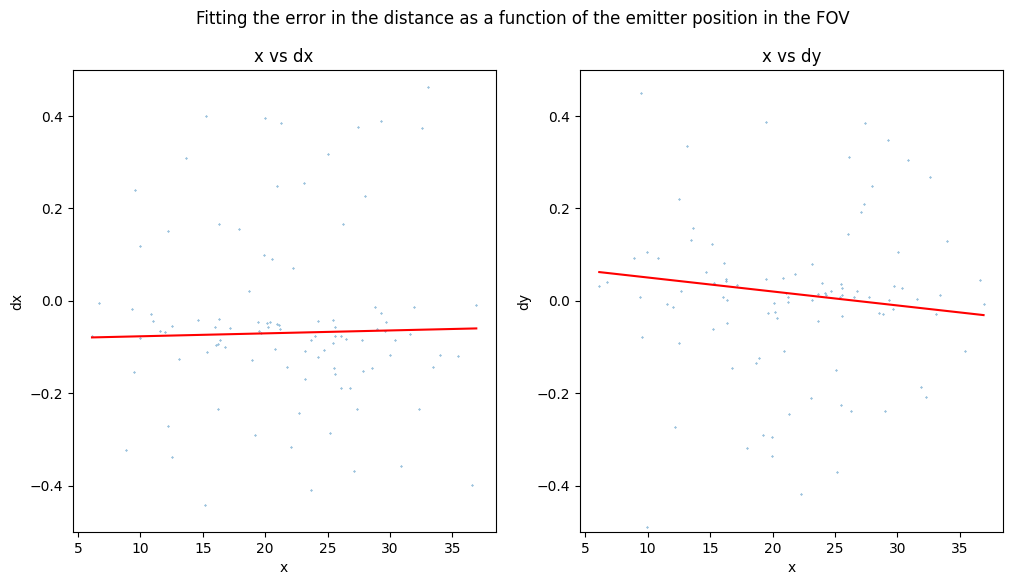

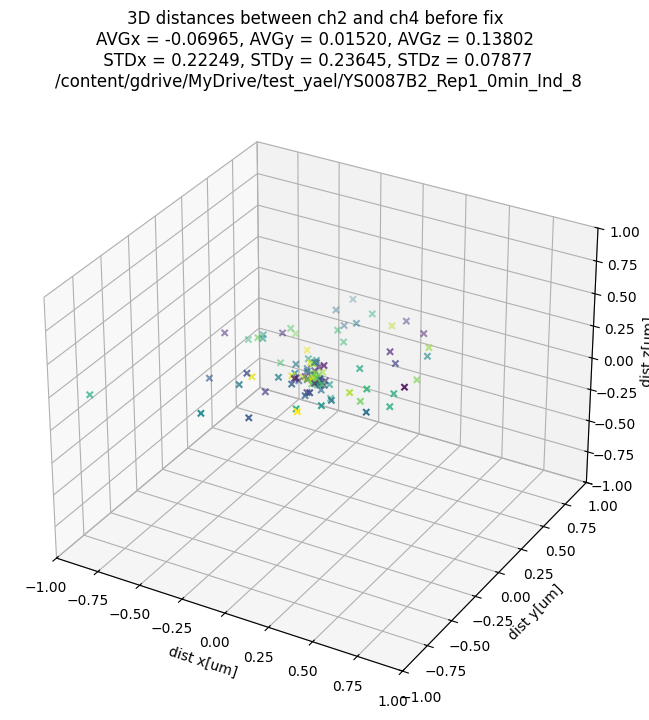

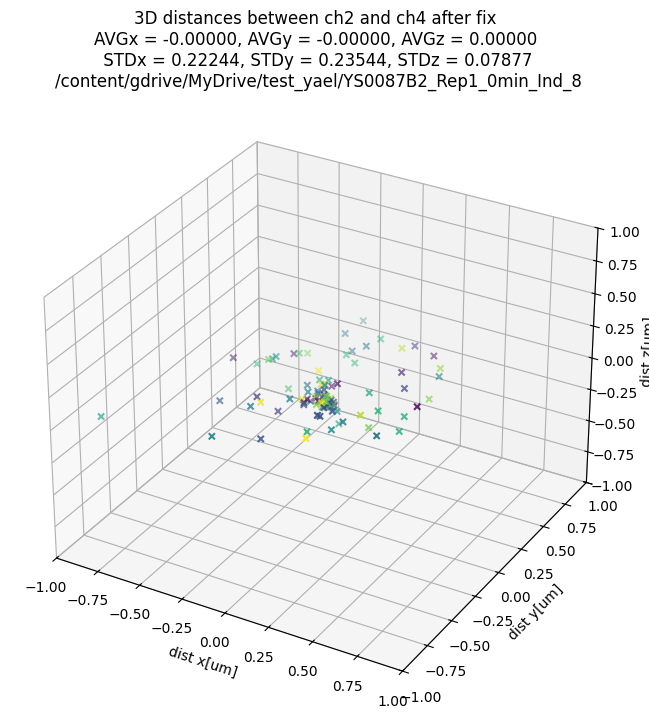

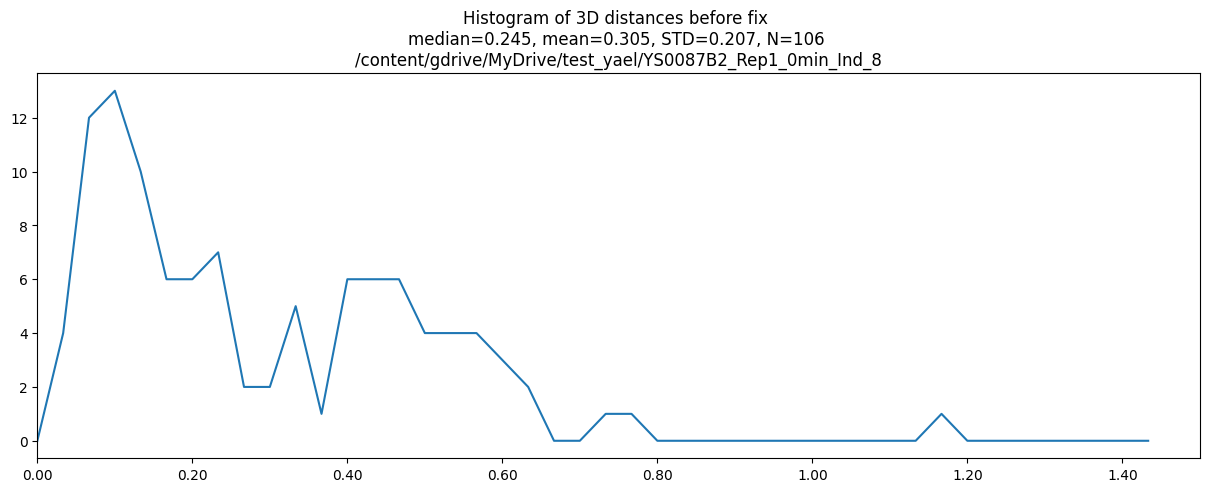

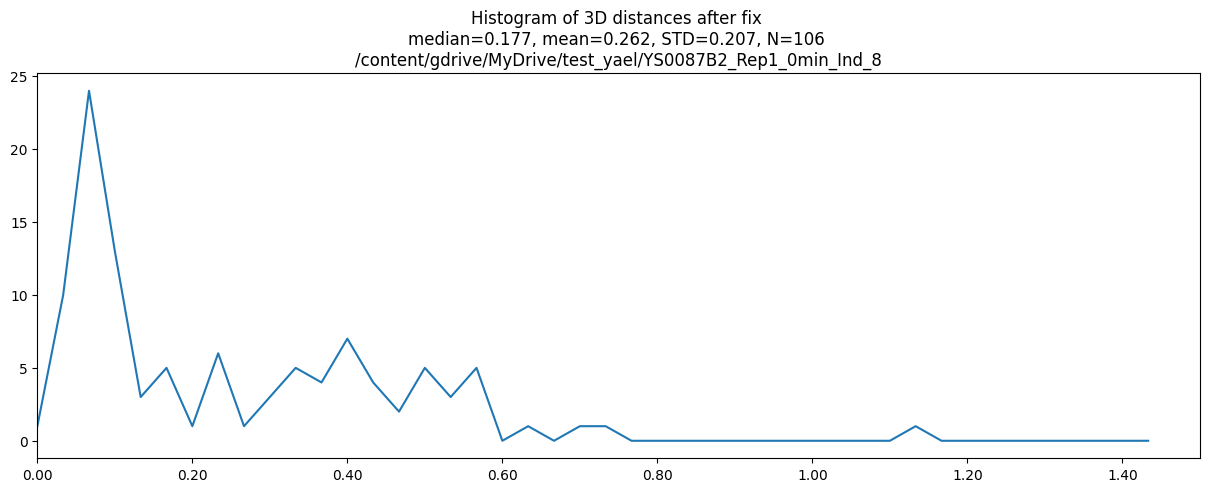

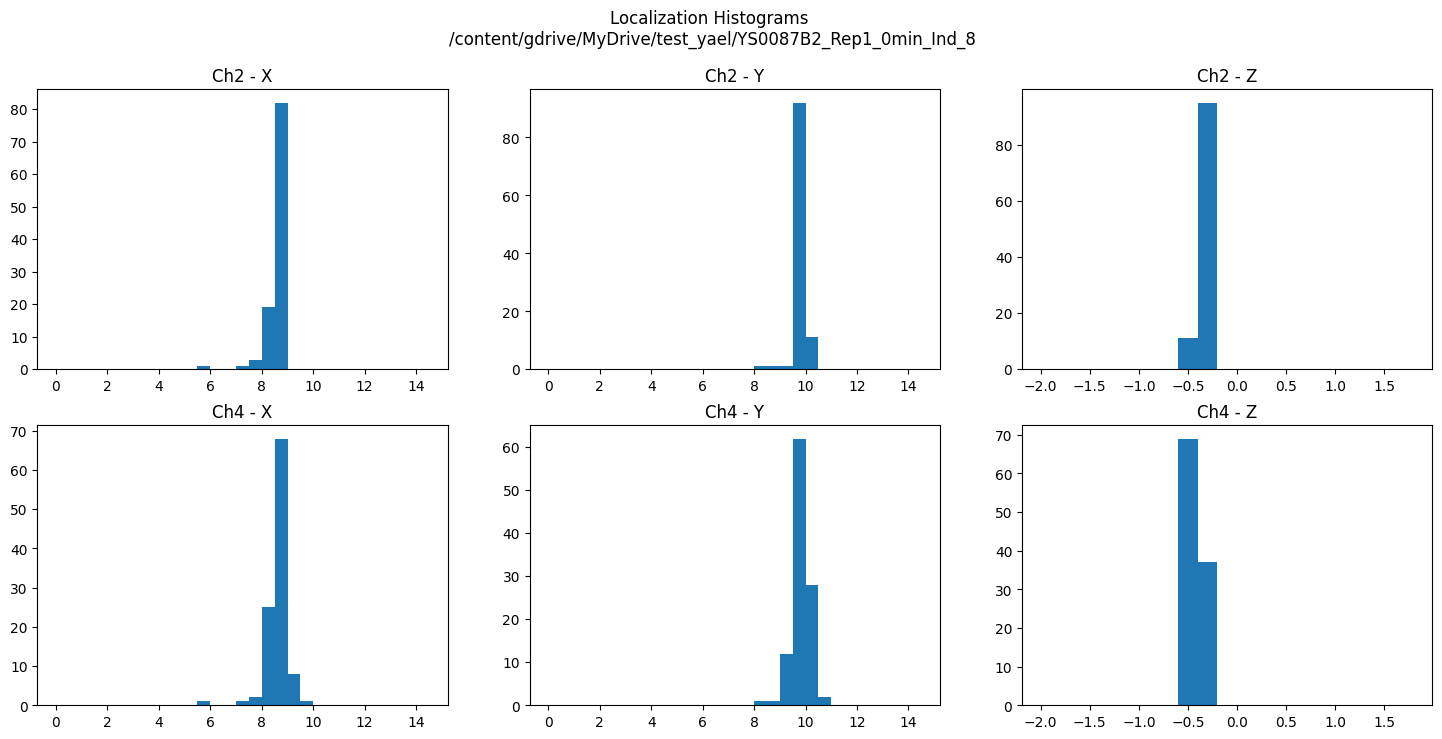

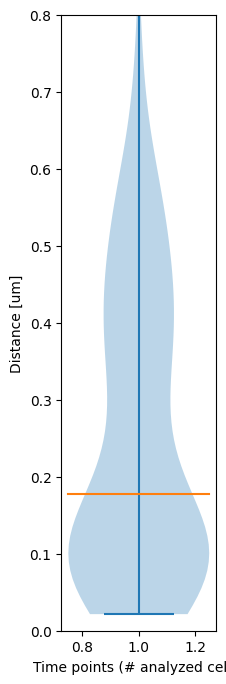

In [ ]:
#@markdown Run this cell to show and save plots showing the run's results
import csv
list_of_median_lists = []
list_of_timepoints = []
list_of_intensity_ch01_lists = []
list_of_rawmax_ch01_lists = []
for dir_path in dirs:
    if (not analyze_beads_and_cells and "BeadsOnly" in dir_path):
        continue

    median_list = []
    if (bootstrap_reps == 1):
        excel_dict = {}
        excel_index = 0

    intensity_ch01_list = []
    rawmax_ch01_list = []
    for bs_i in range(bootstrap_reps):
        file_to_read = open(os.path.join(dir_path, "ch2_bs_{}_dict.pkl".format(bs_i)), "rb")
        ch2_dict = pickle.load(file_to_read)
        file_to_read = open(os.path.join(dir_path, "ch4_bs_{}_dict.pkl".format(bs_i)), "rb")
        ch4_dict = pickle.load(file_to_read)

        analyzed_list = np.load(os.path.join(dir_path, 'analyzed_list_{}.npy'.format(bs_i)))
        ch2_loc_list = []
        ch4_loc_list = []
        dist_list = []
        dist_3d_list = []
        count_problematic_cells = 0
        with open(os.path.join(data_path, dir_path.split('\\')[-1]) + '.txt', 'r') as txt_file:
            lines = []
            cnt = 0
            for line in txt_file:
                lines.append(line)
                if (line.split('\t')[0] == "Object Number"):
                    ind_offset = cnt
                cnt += 1
            cols = lines[ind_offset].split('\t')
            ind_offset += 1
            # Find the right columns
            for col in range(len(cols)):
                if (cols[col] == "Raw Centroid X"):
                    CentColX = col
                if (cols[col] == "Intensity_MC_Ch01"):
                    I_Ch01_col = col
                if (cols[col] == "Raw Max Pixel_MC_Ch01"):
                    RawMax_Ch01_col = col

            # Generate statistics regarding Centroid X and Y
            cent_x_list = []
            cent_y_list = []
            for i in range(ind_offset, len(lines) - 2):
                cent_x_list.append(float(lines[i].split('\t')[CentColX]))
                intensity_ch01_list.append(float(lines[i].split('\t')[I_Ch01_col]))
                rawmax_ch01_list.append(float(lines[i].split('\t')[RawMax_Ch01_col]))

            mean_cent_x = np.mean(cent_x_list)
            mean_cent_y = np.mean(cent_y_list)
            std_cent_x = np.std(cent_x_list)
            std_cent_y = np.std(cent_y_list)

            Cent_vs_dist_X = []
            Cent_vs_dist_Y = []
            for i in range(len(ch2_dict)):
                # Don't use beads/ cells that are located farther than one STD from the mean location
                if (np.abs(float(lines[analyzed_list[i] + ind_offset].split('\t')[CentColX]) - mean_cent_x) > std_cent_x):
                    # print("Localization is too far from the center of the sensor")
                    count_problematic_cells += 1
                    continue
                if (ch2_dict[i][2] > 0 and ch4_dict[i][2] > 0):
                    if (ch2_dict[i][2] != ch4_dict[i][2]):
                        # print("Found different number of loci in ch2 and ch4")
                        count_problematic_cells += 1
                        continue
                    # Assign emitter from ch2 to ch4
                    if (ch2_dict[i][2] <= 1):
                        ind_ch4 = [0]
                    else:
                        ind_ch4 = find_minimal_distance_assignment(ch2_dict[i][1], ch4_dict[i][1])
                    for emitter in range(ch2_dict[i][2]):
                        cur_emitter_ch2 = ch2_dict[i][1][emitter]
                        cur_emitter_ch4 = ch4_dict[i][1][ind_ch4[emitter]]
                        ch2_loc = pixel_size * (np.concatenate([ch2_dict[0][0], np.zeros(1)], axis=0) + cur_emitter_ch2)
                        ch4_loc = pixel_size * (np.concatenate([ch4_dict[0][0], np.zeros(1)], axis=0) + cur_emitter_ch4)

                        # Filter cells where the distance is bigger than ~ the nucleus size
                        tot_dist = np.sqrt((ch2_loc[0] - ch4_loc[0]) ** 2 + (ch2_loc[1] - ch4_loc[1]) ** 2 + (ch2_loc[2] - ch4_loc[2]) ** 2)
                        if (tot_dist < 1.5):
                            ch2_loc_list.append(ch2_loc)
                            ch4_loc_list.append(ch4_loc)
                            dist_list.append(tot_dist)
                            dist_3d_list.append([ch2_loc[0] - ch4_loc[0], ch2_loc[1] - ch4_loc[1], ch2_loc[2] - ch4_loc[2]])

                            # Create points of centroid vs total distance
                            Cent_vs_dist_X.append([lines[i + ind_offset].split('\t')[CentColX], ch2_loc[0] - ch4_loc[0]])
                            Cent_vs_dist_Y.append([lines[i + ind_offset].split('\t')[CentColX], ch2_loc[1] - ch4_loc[1]])

                            ch2_sigX = ch2_dict[i][4][emitter][0]
                            ch2_sigY = ch2_dict[i][4][emitter][1]
                            ch4_sigX = ch4_dict[i][4][emitter][0]
                            ch4_sigY = ch4_dict[i][4][emitter][1]

                            if (bootstrap_reps == 1):
                                # Save localization and distance before correction
                                excel_dict[excel_index] = [analyzed_list[i] + 1, ch2_loc[0], ch2_loc[1], ch2_loc[2],
                                                           ch2_sigX, ch2_sigY, ch4_loc[0], ch4_loc[1], ch4_loc[2],
                                                           ch4_sigX, ch4_sigY, dist_3d_list[-1][0], dist_3d_list[-1][1],
                                                           dist_3d_list[-1][2], 0, 0, 0]
                                excel_index += 1
                        else:
                            # print('Loci distance bigger than 1.5um {}'.format(i))
                            count_problematic_cells += 1
                else:
                    count_problematic_cells += 1

        print('Analayzed {:.2f} out of {:.2f} cells - {:.2f} %'.format(len(ch2_dict) - count_problematic_cells,
                                                                       len(ch2_dict),
                                                                       100 * (len(ch2_dict) - count_problematic_cells) / len(ch2_dict)))
        print('-I- Generating fix curve based on position in FOV vs distance')

        Cent_vs_dist_X = np.array(Cent_vs_dist_X, dtype=float)
        Cent_vs_dist_Y = np.array(Cent_vs_dist_Y, dtype=float)

        ind_curve_X = np.argsort(Cent_vs_dist_X[:, 0])
        ind_curve_Y = np.argsort(Cent_vs_dist_Y[:, 0])

        guess = [1, 1]
        bounds = ([-np.inf, -np.inf], [np.inf, np.inf])

        params_X, _ = opt.curve_fit(linear_func, Cent_vs_dist_X[ind_curve_X, 0], Cent_vs_dist_X[ind_curve_X, 1], p0=guess, bounds=bounds)
        params_Y, _ = opt.curve_fit(linear_func, Cent_vs_dist_Y[ind_curve_Y, 0], Cent_vs_dist_Y[ind_curve_Y, 1], p0=guess, bounds=bounds)

        if(bootstrap_reps == 1):
         # Plot curve fit
            PlotCentroidCurveFit(dir_path, Cent_vs_dist_X, ind_curve_X, params_X, Cent_vs_dist_Y, ind_curve_Y, params_Y)

        dist_3d = np.array(dist_3d_list)
        mean_x_dist = np.mean(linear_func(Cent_vs_dist_X[:, 0], *params_X))
        mean_y_dist = np.mean(linear_func(Cent_vs_dist_Y[:, 0], *params_Y))
        dist_3d_fix = np.copy(dist_3d)
        for loc in range(dist_3d_fix.shape[0]):
            # Compensate on the additional error added because of emitter position
            dist_3d_fix[loc, 0] = dist_3d[loc, 0] - linear_func(Cent_vs_dist_X[loc, 0], *params_X)
            dist_3d_fix[loc, 1] = dist_3d[loc, 1] - linear_func(Cent_vs_dist_Y[loc, 0], *params_Y)
            dist_3d_fix[loc, 2] = dist_3d[loc, 2] - np.mean(dist_3d[:, 2])
        fixed_dist_list = np.zeros_like(np.array(dist_list))
        for loc in range(len(dist_list)):
            fixed_dist_list[loc] = np.sqrt(dist_3d_fix[loc, 0] ** 2 +
                                           dist_3d_fix[loc, 1] ** 2 +
                                           dist_3d_fix[loc, 2] ** 2)
        # open the file in the write mode
        if (bootstrap_reps == 1):
            with open(os.path.join(dir_path, "raw_data3D.csv"), 'w', encoding='UTF8', newline='') as f:
                # create the csv writer
                writer = csv.writer(f)
                writer.writerow(['frame', 'ch2_x [um]', 'ch2_y [um]', 'ch2_z [um]', 'ch2_sigX', 'ch2_sigY',
                                 'ch4_x [um]', 'ch4_y [um]', 'ch4_z [um]', 'ch4_sigX', 'ch4_sigY',
                                 'dist_x', 'dist_y', 'dist_z', 'dist_x_fix', 'dist_y_fix', 'dist_z_fix'])

                for i in range(len(excel_dict)):
                    excel_dict[i][-3] = dist_3d_fix[i, 0]
                    excel_dict[i][-2] = dist_3d_fix[i, 1]
                    excel_dict[i][-1] = dist_3d_fix[i, 2]
                    # write a row to the csv file
                    writer.writerow(excel_dict[i])

            np.save(os.path.join(dir_path, 'dist_arr'), np.array(dist_list))

            # =============================================================================================================
            # Plot 3d distance scatter
            Plot3DDistanceScatter('3D distances between ch2 and ch4 before fix', dir_path, dist_3d)
            Plot3DDistanceScatter('3D distances between ch2 and ch4 after fix', dir_path, dist_3d_fix)

            # =============================================================================================================
            from matplotlib import ticker

            # Plot 3d distance histogram
            Plot3DDistanceHistogram('Histogram of 3D distances before fix', dir_path, dist_list)
            Plot3DDistanceHistogram('Histogram of 3D distances after fix', dir_path, fixed_dist_list)

            np.save(os.path.join(dir_path, 'fixed_dist_arr'), np.array(fixed_dist_list))
            # =============================================================================================================
            # Plot 3D localization histogram
            Plot3DLocalizationHistogram('3D_localization_histograms before_fix', dir_path, ch2_loc_list, ch4_loc_list)

        median_list.append(np.median(fixed_dist_list))

    # Append all the tracked parameters list for each time point
    if("BeadsOnly" not in dir_path):
        list_of_intensity_ch01_lists.append(np.array(intensity_ch01_list))
        list_of_rawmax_ch01_lists.append(np.array(rawmax_ch01_list))
        list_of_median_lists.append(median_list)
        if('min' in dir_path.split('\\')[-1]):
            minutes_ind = dir_path.split('\\')[-1].find('min')
            start_ind = dir_path.split('\\')[-1][minutes_ind-5:minutes_ind].rfind('_')
            list_of_timepoints.append(int(dir_path.split('\\')[-1][minutes_ind-5+start_ind+1:minutes_ind]))
            meaningful_ind_flag = True
        else:
            list_of_timepoints.append(dir_path.split('\\')[-1])
            meaningful_ind_flag = False

# Take the mean and std of each list over different bootstrap reps
if(meaningful_ind_flag):
    sort_ind = np.argsort(list_of_timepoints)
else:
    sort_ind = np.arange(len(list_of_timepoints))

median_arr = np.array(list_of_median_lists)
timepoints_arr = np.array(list_of_timepoints)
mean_intensity_ch01 = np.zeros(len(list_of_timepoints))
std_intensity_ch01 = np.zeros(len(list_of_timepoints))
mean_rawmax_ch01 = np.zeros(len(list_of_timepoints))
std_rawmax_ch01 = np.zeros(len(list_of_timepoints))
for i in range(len(list_of_timepoints)):
    mean_intensity_ch01[i] = np.mean(list_of_intensity_ch01_lists[i])
    std_intensity_ch01[i] = np.std(list_of_intensity_ch01_lists[i])
    mean_rawmax_ch01[i] = np.mean(list_of_rawmax_ch01_lists[i])
    std_rawmax_ch01[i] = np.std(list_of_rawmax_ch01_lists[i])

# Channel 1 plots
if(len(std_intensity_ch01) > 1):
    PlotCh01Plots(data_path, bootstrap_reps, timepoints_arr, sort_ind, mean_intensity_ch01,
                  std_intensity_ch01, mean_rawmax_ch01, std_rawmax_ch01)

if (bootstrap_reps > 1):
    # Bootstrap distance error bar plot
    plt.figure(figsize=(8, 4))
    plt.errorbar(timepoints_arr[sort_ind], np.mean(median_arr[sort_ind, :], axis=1),
                 np.std(median_arr[sort_ind, :], axis=1))
    plt.xlabel('time points [min]')
    plt.ylabel('mean median over {} reps'.format(bootstrap_reps))
    plt.title('Bootstrap estimation of error bars over {} reps'.format(bootstrap_reps))
    plt.savefig(os.path.join(data_path, "distance_error_bar_graph.png"))
    if (verbose):
        plt.show()
    plt.close()
else:
    # Count number of relevant dirs
    cnt_dirs = 0
    for dir_path in dirs:
        if ("BeadsOnly" not in dir_path):
            cnt_dirs += 1

    dist_arr_for_plot = np.zeros(cnt_dirs)

    if(cnt_dirs > 1):
      fig, axes = plt.subplots(1, cnt_dirs, sharex=True, figsize=(len(list_of_timepoints), 6))
      fig.suptitle('Violin graph + median')
      axes[0].set_ylabel('Distance distribution')
      ind = 0
      curr_ind = -1
      for dir_path in dirs:
          if ("BeadsOnly" in dir_path):
              continue
          for filename in os.listdir(dir_path):
              if filename.endswith("ch2.tif"):
                  if(meaningful_ind_flag):
                      for index, tp in enumerate(timepoints_arr[sort_ind]):
                          if(("_" + str(tp) + "min") in filename):
                              curr_ind = index
                              break
                  else:
                      curr_ind += 1

                  dist_list = np.load(os.path.join(dir_path, 'fixed_dist_arr.npy'))

                  axes[curr_ind].plot([0.75, 1.25], [np.median(dist_list), np.median(dist_list)])
                  dist_arr_for_plot[curr_ind] = np.mean(dist_list)

                  if (ind == 0):
                      axes[curr_ind].spines["right"].set_visible(False)
                      axes[curr_ind].spines["top"].set_visible(False)
                  else:
                      axes[curr_ind].spines["right"].set_visible(False)
                      axes[curr_ind].spines["top"].set_visible(False)
                      axes[curr_ind].spines["left"].set_visible(False)
                      axes[curr_ind].get_yaxis().set_ticks([])

                  axes[curr_ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                  axes[curr_ind].set_xlabel(str(timepoints_arr[sort_ind[curr_ind]]) + '({})'.format(len(dist_list)))
                  axes[curr_ind].violinplot(dist_list)
                  axes[curr_ind].set_ylim([0, 0.8])
          ind += 1

          fig.text(0.5, 0, 'Time points (# analyzed cells)', ha='center')
          fig.text(-0.15, 0.5, 'Distance [um]', va='center', rotation='vertical')
          plt.savefig(os.path.join(data_path, "violin_graph_3D.png"))
          if (verbose):
              plt.show()
          plt.close()
    else:
        plt.figure(figsize=(2, 8))
        dist_list = np.load(os.path.join(dir_path, 'fixed_dist_arr.npy'))
        plt.violinplot(dist_list)
        plt.plot([0.75, 1.25], [np.median(dist_list), np.median(dist_list)])
        plt.ylim([0, 0.8])
        plt.xlabel('Time points (# analyzed cells)')
        plt.ylabel('Distance [um]')
        plt.savefig(os.path.join(data_path, "violin_graph_3D.png"))
        if (verbose):
            plt.show()
        plt.close()